# Predicting Tweet Sentiment With Emojis
### Aashni Manroa
In my project, I will be using a dataset from Kaggle titled "Tweets With Emoji" to test if adding emojis to a Naive Bayes prediction model will improve the sentiment analysis for the tweets.

Link to dataset: https://www.kaggle.com/datasets/ericwang1011/tweets-with-emoji?select=saluting_face.csv

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

## Preprocessing Emoji Data

I used this preprocessing to create a labeled.csv file that contained small but equal amounts of tweets containing each emoji. I then downloaded this csv and manually labeled the sentiments of each one. 

In [3]:
import glob
path = "data/*.csv"
merged = pd.DataFrame(columns=['Text', 'emoji'])
#labeled = pd.DataFrame(columns=['Text', 'emoji', 'Sentiment'])
#labeled.to_csv('_labeled.csv', mode='a', index=False)
for fname in glob.glob(path):
    read = pd.read_csv(fname, lineterminator='\n')  
    #train, test = train_test_split(read, test_size=0.999)

    half_1, half_2 = train_test_split(read, test_size=0.8)
    name_split = fname.split("/")
    new_name = name_split[1][:len(name_split[1])-4]
    read['emoji'] = new_name
    half_1['emoji'] = new_name
    #train['emoji'] = new_name
    #train.to_csv('_labeled.csv', mode='a', index=False, header=False)
    
    #merged = pd.concat([merged, read], ignore_index=True, axis=0)
    merged = pd.concat([merged, half_1], ignore_index=True, axis=0)

In [4]:
merged.tail()

,Text,emoji
171995,@xikers_official HAPPY BIRTHDAY MINJAE!!!!! 🥳💗,partying_face
171996,@andie1105 Swan Lake becomes Whale Lake 🙄,partying_face
171997,BaylorAthletics: Come early to tonight’s @Bayl...,partying_face
171998,@FoziaAliZafar31 Then don't. You will get what...,partying_face
171999,Happy birthday @LoneChildMJB 🥳 have a good one 🎂,partying_face


## Downloading NLTK 

In [5]:
pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2023.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached regex-2023.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (785 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples
from nltk.tokenize import TweetTokenizer

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading manually labeled data and fixing column names

In [8]:
labeled = pd.read_csv("_labeled_final.csv", lineterminator='\n') 
labeled.head()

,Text,emoji,Sentiment\r
0,@kirawontmiss @Miki1_O It didn’t but thank you 🥰,smiling_face_with_hearts,1
1,@RosePinochet Stop being friends with so many ...,smiling_face_with_hearts,0
2,@madameraerae Lolz 😂 her sweet &amp; adorable ...,smiling_face_with_hearts,1
3,I want this rabbit so cute 🥰 https://t.co/XWeZ...,smiling_face_with_hearts,1
4,@lily_dusk Lily so cute!!! 🥰,smiling_face_with_hearts,1


In [9]:
labeled.columns = [c.replace("\r", "") for c in labeled.columns]
labeled.columns = [c.replace("emoji", "Emoji") for c in labeled.columns]
labeled

,Text,Emoji,Sentiment
0,@kirawontmiss @Miki1_O It didn’t but thank you 🥰,smiling_face_with_hearts,1
1,@RosePinochet Stop being friends with so many ...,smiling_face_with_hearts,0
2,@madameraerae Lolz 😂 her sweet &amp; adorable ...,smiling_face_with_hearts,1
3,I want this rabbit so cute 🥰 https://t.co/XWeZ...,smiling_face_with_hearts,1
4,@lily_dusk Lily so cute!!! 🥰,smiling_face_with_hearts,1
...,...,...,...
855,@xikers_official happy birthday king !! love u...,partying_face,1
856,@MissYanfe What your Birthday 🥳,partying_face,1
857,@fynnbarr Happy birthday 🥳. May be blessings o...,partying_face,1
858,Congratulations @0xpickanya 🥳\n\n you won $15🏆...,partying_face,1


## Graphing positive and negative tweets in training set

In [10]:
positive_tweets = []
negative_tweets = []
for index, row in labeled.iterrows():
    if row['Sentiment'] == 1:
        positive_tweets.append(row['Text'])
    elif row['Sentiment'] == 0:
        negative_tweets.append(row['Text'])

In [11]:
len(positive_tweets), len(negative_tweets)

(589, 271)

Text(0.5, 0, 'Tweet Length')

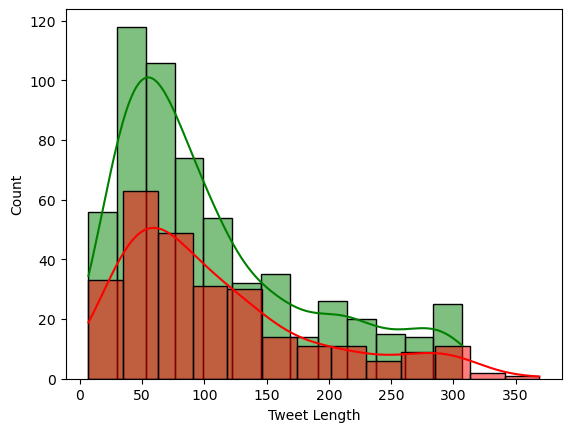

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot([len(tweet) for tweet in positive_tweets], kde=True, color='green', label='Positive')
sns.histplot([len(tweet) for tweet in negative_tweets], kde=True, color='red', label='Negative')
plt.xlabel("Tweet Length")

## Test a Naive Bayes Model on the full dataset

I wanted to train my model on this small, 860 length dataset and then try to predict the sentiments of the remaining thousands of samples. This may take a while to run, but it produces a graph that looks similar to the graph above. The problem is that because the testing samples don't have assigned sentiments, I have no way to test their accuracy. I had to find another way to test accuracy of my model.

In [16]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [18]:
import re
import string
import emoji

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    """Input: tweet a string containing a tweet
    Return:
    tweets_clean: a list of words containing the processed tweet
    """
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    
    # Instantiate stemmer class
    stemmer = PorterStemmer()
    
    # Create stopwords list
    stopwords_english = stopwords.words('english')
    
    # Tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # Tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        word = emoji.replace_emoji(word, '')
        if (word not in stopwords_english and word not in string.punctuation and word != '’' and 
            (word.isalpha() or "_" in word)):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    return tweets_clean

In [19]:
## Let's create a dictionary of words and their frequencies
def count_tweets(result, tweets, ys):
    """Input:
    result: a dictionary that will contain the frequency of each pair (word, label)
    tweets: a list of tweets
    ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    """
    # iterate through each tweet and its label
    for y, tweet in zip(ys, tweets):
        # process the tweet to get the words in the form of a list
        for word in process_tweet(tweet):
            # increment the word count for the pair (word, label)
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
    return result

In [20]:
y_train = labeled['Sentiment']

In [21]:
X_train = labeled['Text'] + ' ' + labeled['Emoji']

In [22]:
freqs = count_tweets({}, X_train, y_train)

In [23]:
def naive_bayes(freqs, X_train, y_train):
    """Train a Naive Bayes classifier on twitter data.

    Args:
        freqs (dict): dictionary of (word, label): frequency pairs
        X_train (list): list of tweets
        y_train (list): list of tweets
        
    returns:
    logprior (float): log prior
    loglikelihood (dict): dictionary of (word, label): log likelihood pairs
    """
    ## Compare the code here with Jurafsky and Martin's pseudocode
    
    loglikelihood = {}
    logprior = 0
    
    vocab = set([pair[0] for pair in freqs.keys()]) # words in the vocabulary
    V = len(vocab) # number of unique words in the vocabulary
    
    # Calculate N_pos and N_neg tweets (number of positive and negative tweets)
    N_pos, N_neg = 0, 0 # number of positive and negative tweets
    
    # Calculate the number of positive and negative tweets
    for pair in freqs.keys():
        # positive tweets
        if int(pair[1]) > 0:
            N_pos += freqs[pair]
        # negative tweets
        else:
            N_neg += freqs[pair]
    
    # Documents = total number of tweets
    D = len(X_train)
    
    # Calculate # of positive and negative documents
    D_pos = np.sum(y_train)
    D_neg = D - D_pos
    
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)
        
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
    
    return logprior, loglikelihood

In [24]:
logprior, loglikelihood = naive_bayes(freqs, X_train, y_train)

In [25]:
def predict_naive_bayes(tweet, logprior, loglikelihood):
    """Input:
    tweet: a string
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
    """
    word_l = process_tweet(tweet)
    
    p = 0
    p += logprior
    
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
    
    return p

In [33]:
test = merged[(~merged.Text.isin(labeled.Text))]

In [34]:
test.head()

,Text,emoji
0,@appelpoes lmfao ofc it’ll be easy bcs i love ...,smiling_face_with_hearts
1,@mama_mochi7 You too Carrie!! LY 🥰 😘💜,smiling_face_with_hearts
2,I can’t wait for Stomp Wars step competition 😇...,smiling_face_with_hearts
3,"hello i find you really pretty hehe — hii, tha...",smiling_face_with_hearts
4,this lil guy keeping me company while i decora...,smiling_face_with_hearts


In [35]:
test_tweet = test['Text'] + ' ' + test['emoji']
results_df = pd.DataFrame(columns = ['Text + Emoji', 'Sentiment'])
results = []
results_clean = []
positive_test_tweets = []
negative_test_tweets = []
for t in test_tweet:
    raw = predict_naive_bayes(t, logprior, loglikelihood)
    results.append(raw)
    if raw <= 0:
        results_clean.append(0)
        negative_test_tweets.append(t)
        results_df.loc[len(results_df.index)] = [t, 0] 
    elif raw > 0:
        results_clean.append(1)
        positive_test_tweets.append(t)
        results_df.loc[len(results_df.index)] = [t, 1] 
    #print( '%s -> %f' % (t, predict_naive_bayes(t, logprior, loglikelihood)))

In [36]:
len(positive_test_tweets), len(negative_test_tweets)

(129484, 42312)

<Axes: ylabel='Count'>

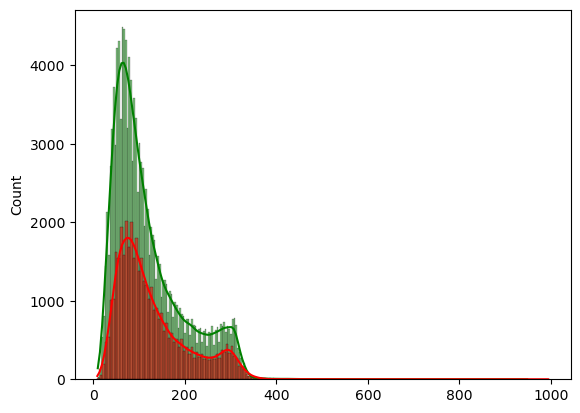

In [37]:
sns.histplot([len(tweet) for tweet in positive_test_tweets], kde=True, color='green', label='Positive')
sns.histplot([len(tweet) for tweet in negative_test_tweets], kde=True, color='red', label='Negative')

Examples of positive and negative tweets that the model categorized:

In [38]:
from numpy.random import randint

In [43]:
positive_test_tweets[randint(0, len(positive_test_tweets))]

'@JeremyRenner \nHope you heal quickly we need you either way no matter what condition or how battlewarn you are ok!!!!!!! Be kind to yourself.\n2 nd commandment love your neighbor as you love yourself.\nSo love yourself!!!!! HAPPY EASTER!!!🐇🐇🐇🐇🐇 rabbit'

In [44]:
negative_test_tweets[randint(0, len(negative_test_tweets))]

'💔 says multiple casualties, heard 8 people atleast was hit &amp; one officer was down on the steps with a head shot 💔 so sad man white_heart'

In [45]:
results_df.head()

,Text + Emoji,Sentiment
0,@appelpoes lmfao ofc it’ll be easy bcs i love ...,0
1,@mama_mochi7 You too Carrie!! LY 🥰 😘💜 smiling_...,1
2,I can’t wait for Stomp Wars step competition 😇...,0
3,"hello i find you really pretty hehe — hii, tha...",1
4,this lil guy keeping me company while i decora...,1


In order to get an actual accuracy for my model, I wanted to run 4 trials.

## Testing Text With No Emojis

In [22]:
X_train, X_test, y_train, y_test = train_test_split(labeled['Text'],
                                                    labeled['Sentiment'],
                                                    test_size=0.2,
                                                    random_state=123)

len(X_train), len(X_test), len(y_train), len(y_test)

(688, 172, 688, 172)

In [24]:
import re
import string
import emoji

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    """Input: tweet a string containing a tweet
    Return:
    tweets_clean: a list of words containing the processed tweet
    """
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    
    # Instantiate stemmer class
    stemmer = PorterStemmer()
    
    # Create stopwords list
    stopwords_english = stopwords.words('english')
    
    # Tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # Tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        word = emoji.replace_emoji(word, '')
        if (word not in stopwords_english and word not in string.punctuation and word != '’' and 
            (word.isalpha() or "_" in word)):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    return tweets_clean

In [25]:
## Let's create a dictionary of words and their frequencies
def count_tweets(result, tweets, ys):
    """Input:
    result: a dictionary that will contain the frequency of each pair (word, label)
    tweets: a list of tweets
    ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    """
    # iterate through each tweet and its label
    for y, tweet in zip(ys, tweets):
        # process the tweet to get the words in the form of a list
        for word in process_tweet(tweet):
            # increment the word count for the pair (word, label)
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
    return result

In [26]:
freqs = count_tweets({}, X_train, y_train)

In [27]:
## Let's create a function to extract the features from the tweets

def naive_bayes(freqs, X_train, y_train):
    """Train a Naive Bayes classifier on twitter data.

    Args:
        freqs (dict): dictionary of (word, label): frequency pairs
        X_train (list): list of tweets
        y_train (list): list of tweets
        
    returns:
    logprior (float): log prior
    loglikelihood (dict): dictionary of (word, label): log likelihood pairs
    """
    ## Compare the code here with Jurafsky and Martin's pseudocode
    
    loglikelihood = {}
    logprior = 0
    
    vocab = set([pair[0] for pair in freqs.keys()]) # words in the vocabulary
    V = len(vocab) # number of unique words in the vocabulary
    
    # Calculate N_pos and N_neg tweets (number of positive and negative tweets)
    N_pos, N_neg = 0, 0 # number of positive and negative tweets
    
    # Calculate the number of positive and negative tweets
    for pair in freqs.keys():
        # positive tweets
        if pair[1] > 0:
            N_pos += freqs[pair]
        # negative tweets
        else:
            N_neg += freqs[pair]
    
    # Documents = total number of tweets
    D = len(X_train)
    
    # Calculate # of positive and negative documents
    D_pos = np.sum(y_train)
    D_neg = D - D_pos
    
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)
        
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
    
    return logprior, loglikelihood

In [28]:
logprior, loglikelihood = naive_bayes(freqs, X_train, y_train)

In [32]:
def predict_naive_bayes(tweet, logprior, loglikelihood):
    """Input:
    tweet: a string
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
    """
    word_l = process_tweet(tweet)
    
    p = 0
    p += logprior
    
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
    
    return p

In [33]:
labeled_positive_test_tweets = []
labeled_negative_test_tweets = []
test_df = pd.DataFrame(columns = ['Text', 'Calculated', 'Actual'])

In [34]:
def test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets):
    """Input:
    X_test: a list of tweets
    y_test: (m, 1) array with the sentiment label of each tweet (either 0 or 1)
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # Let's score the accuracy of our model
    accuracy = 0
    
    # Our predictions will be stored in y_hat
    y_hat = []
    index1 = 0
    for tweet in X_test:
        index = np.where(labeled['Text'] == tweet)[0][0]
        #print(index)
        actual = labeled._get_value(index, 'Sentiment')
        #print(index, actual)
        if predict_naive_bayes(tweet, logprior, loglikelihood) > 0:
            y_hat.append(1)
            labeled_positive_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':1, 'Actual':actual})
        else:
            y_hat.append(0)
            labeled_negative_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':0, 'Actual':actual})
        index1 = index1 + 1
    
    # error is the average of the absolute values of the differences between y_hat and y_test
    error = np.mean(np.abs(y_hat - y_test))
    
    accuracy = 1 - error
    
    return accuracy

In [35]:
print("Naive Bayes accuracy = %f" % test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets))

Naive Bayes accuracy = 0.691860


All of the misclassified tweets:

In [41]:
for x in np.where(test_df['Calculated'] != test_df['Actual'])[0]:
    print(test_df._get_value(x, 'Text'))
    print("Calculated:", test_df._get_value(x, 'Calculated'), "Actual:", test_df._get_value(x, 'Actual'))
    print("<======>")

@ethy_yopi @AishaDaughter Sis I totally agree, that’s why I love the rural parts of Africa where the ppl haven’t been corrupted by European stands of beauty……

These kinda list don’t help African women at all, they just cause more damage &amp; insecurities bc of where they come on these stupid list.😤😡😡
Calculated: 1 Actual: 0
<======>
instead of reading the near constant negativity both in the tl and in my dm’s - im gonna log off for the rest of the weekend 😵‍💫😶🫠 

pls keep streaming for yoonmin! 
https://t.co/kdfwMP1ZWL https://t.co/vJXMmGEzjv
Calculated: 1 Actual: 0
<======>
Isa pa tong your name engraved herein 🖕🖕🖕
Calculated: 1 Actual: 0
<======>
This is what inspires me to go out and get ppl to register to vote. Ain’t no way I’m going to listen to 4 years of trump having a platform to call a grievance press conference every damn day. #Imsickofallthisshit🙄😡
Calculated: 0 Actual: 1
<======>
@ReallyAceryl i haven’t been keeping up with this who’s been harassing my nandor 😤😤😤😤
Calcula

Example of tweets that were labeled as positive and negative - regardless of their actual classifications

In [37]:
labeled_positive_test_tweets[randint(0, len(labeled_positive_test_tweets))]

'No more polambalzzz nly positive vibez in my TL hereafter 🤍🧘✨🕊 https://t.co/cZOryIxh0c'

In [38]:
labeled_negative_test_tweets[randint(0, len(labeled_negative_test_tweets))]

"🌹hello, we've been back into studying Japanese again lately so we might just start tweeting in Japanese a bit here and there so if we do just click on the translate tweet button and it'll show you what we're saying lol"

## Testing Text With One Emoji

In [46]:
labeled['Combined'] = labeled['Text'] + ' ' + labeled['Emoji']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(labeled['Combined'],
                                                    labeled['Sentiment'],
                                                    test_size=0.2,
                                                    random_state=123)

len(X_train), len(X_test), len(y_train), len(y_test)

(688, 172, 688, 172)

In [48]:
import re
import string
import emoji

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    """Input: tweet a string containing a tweet
    Return:
    tweets_clean: a list of words containing the processed tweet
    """
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    
    # Instantiate stemmer class
    stemmer = PorterStemmer()
    
    # Create stopwords list
    stopwords_english = stopwords.words('english')
    
    # Tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # Tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        word = emoji.replace_emoji(word, '')
        #if emoji.is_emoji(word):
            #tweets_clean.append(word)
        if (word not in stopwords_english and word not in string.punctuation and word != '’' and 
            (word.isalpha() or "_" in word)):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    return tweets_clean

In [49]:
## Let's create a dictionary of words and their frequencies
def count_tweets(result, tweets, ys):
    """Input:
    result: a dictionary that will contain the frequency of each pair (word, label)
    tweets: a list of tweets
    ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    """
    # iterate through each tweet and its label
    for y, tweet in zip(ys, tweets):
        # process the tweet to get the words in the form of a list
        for word in process_tweet(tweet):
            # increment the word count for the pair (word, label)
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
    return result

In [50]:
freqs = count_tweets({}, X_train, y_train)

In [51]:
## Let's create a function to extract the features from the tweets

def naive_bayes(freqs, X_train, y_train):
    """Train a Naive Bayes classifier on twitter data.

    Args:
        freqs (dict): dictionary of (word, label): frequency pairs
        X_train (list): list of tweets
        y_train (list): list of tweets
        
    returns:
    logprior (float): log prior
    loglikelihood (dict): dictionary of (word, label): log likelihood pairs
    """
    ## Compare the code here with Jurafsky and Martin's pseudocode
    
    loglikelihood = {}
    logprior = 0
    
    vocab = set([pair[0] for pair in freqs.keys()]) # words in the vocabulary
    V = len(vocab) # number of unique words in the vocabulary
    
    # Calculate N_pos and N_neg tweets (number of positive and negative tweets)
    N_pos, N_neg = 0, 0 # number of positive and negative tweets
    
    # Calculate the number of positive and negative tweets
    for pair in freqs.keys():
        # positive tweets
        if pair[1] > 0:
            N_pos += freqs[pair]
        # negative tweets
        else:
            N_neg += freqs[pair]
    
    # Documents = total number of tweets
    D = len(X_train)
    
    # Calculate # of positive and negative documents
    D_pos = np.sum(y_train)
    D_neg = D - D_pos
    
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)
        
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
    
    return logprior, loglikelihood

In [52]:
logprior, loglikelihood = naive_bayes(freqs, X_train, y_train)

In [53]:
def predict_naive_bayes(tweet, logprior, loglikelihood):
    """Input:
    tweet: a string
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
    """
    word_l = process_tweet(tweet)
    
    p = 0
    p += logprior
    
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
    
    return p

In [54]:
labeled_positive_test_tweets = []
labeled_negative_test_tweets = []
test_df = pd.DataFrame(columns = ['Text', 'Calculated', 'Actual'])

In [55]:
def test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets):
    """Input:
    X_test: a list of tweets
    y_test: (m, 1) array with the sentiment label of each tweet (either 0 or 1)
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # Let's score the accuracy of our model
    accuracy = 0
    
    # Our predictions will be stored in y_hat
    y_hat = []
    index1 = 0
    for tweet in X_test:
        index = labeled.index[labeled['Combined'] == tweet].tolist()[0]
        actual = labeled._get_value(index, 'Sentiment')
        #print(index, actual)
        if predict_naive_bayes(tweet, logprior, loglikelihood) > 0:
            y_hat.append(1)
            labeled_positive_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':1, 'Actual':actual})
        else:
            y_hat.append(0)
            labeled_negative_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':0, 'Actual':actual})
        index1 = index1 + 1
    
    # error is the average of the absolute values of the differences between y_hat and y_test
    error = np.mean(np.abs(y_hat - y_test))
    
    accuracy = 1 - error
    
    return accuracy

In [56]:
print("Naive Bayes accuracy = %f" % test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets))

Naive Bayes accuracy = 0.784884


All of the misclassified tweets:

In [57]:
for x in np.where(test_df['Calculated'] != test_df['Actual'])[0]:
    print(test_df._get_value(x, 'Text'))
    print("Calculated:", test_df._get_value(x, 'Calculated'), "Actual:", test_df._get_value(x, 'Actual'))
    print("<======>")

@ethy_yopi @AishaDaughter Sis I totally agree, that’s why I love the rural parts of Africa where the ppl haven’t been corrupted by European stands of beauty……

These kinda list don’t help African women at all, they just cause more damage &amp; insecurities bc of where they come on these stupid list.😤😡😡 enraged_face
Calculated: 1 Actual: 0
<======>
instead of reading the near constant negativity both in the tl and in my dm’s - im gonna log off for the rest of the weekend 😵‍💫😶🫠 

pls keep streaming for yoonmin! 
https://t.co/kdfwMP1ZWL https://t.co/vJXMmGEzjv melting_face
Calculated: 1 Actual: 0
<======>
This is what inspires me to go out and get ppl to register to vote. Ain’t no way I’m going to listen to 4 years of trump having a platform to call a grievance press conference every damn day. #Imsickofallthisshit🙄😡 enraged_face
Calculated: 0 Actual: 1
<======>
@ReallyAceryl i haven’t been keeping up with this who’s been harassing my nandor 😤😤😤😤 face_with_steam_from_nose
Calculated: 1 Act

Examples of positive and negatively labeled tweets - regardless of their actual classification.

In [58]:
labeled_positive_test_tweets[randint(0, len(labeled_positive_test_tweets))]

"ada balon², it's time for me to buy a cake for myself😋 face_savoring_food"

In [59]:
labeled_negative_test_tweets[randint(0, len(labeled_negative_test_tweets))]

'@CNN And, just like that #CNN to the rescue! 🖕🖕 middle_finger'

## Testing Text With All Emojis

In [55]:
X_train, X_test, y_train, y_test = train_test_split(labeled['Text'],
                                                    labeled['Sentiment'],
                                                    test_size=0.2,
                                                    random_state=123)

len(X_train), len(X_test), len(y_train), len(y_test)

(688, 172, 688, 172)

In [56]:
import re
import string
import emoji

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    """Input: tweet a string containing a tweet
    Return:
    tweets_clean: a list of words containing the processed tweet
    """
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    
    # Instantiate stemmer class
    stemmer = PorterStemmer()
    
    # Create stopwords list
    stopwords_english = stopwords.words('english')
    
    # Tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # Tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        #word = emoji.replace_emoji(word, '')
        if emoji.is_emoji(word):
            tweets_clean.append(word)
        if (word not in stopwords_english and word not in string.punctuation and word != '’' and 
            (word.isalpha() or "_" in word)):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    return tweets_clean

In [57]:
## Let's create a dictionary of words and their frequencies
def count_tweets(result, tweets, ys):
    """Input:
    result: a dictionary that will contain the frequency of each pair (word, label)
    tweets: a list of tweets
    ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    """
    # iterate through each tweet and its label
    for y, tweet in zip(ys, tweets):
        # process the tweet to get the words in the form of a list
        for word in process_tweet(tweet):
            # increment the word count for the pair (word, label)
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
    return result

In [58]:
freqs = count_tweets({}, X_train, y_train)

In [59]:
## Let's create a function to extract the features from the tweets

def naive_bayes(freqs, X_train, y_train):
    """Train a Naive Bayes classifier on twitter data.

    Args:
        freqs (dict): dictionary of (word, label): frequency pairs
        X_train (list): list of tweets
        y_train (list): list of tweets
        
    returns:
    logprior (float): log prior
    loglikelihood (dict): dictionary of (word, label): log likelihood pairs
    """
    ## Compare the code here with Jurafsky and Martin's pseudocode
    
    loglikelihood = {}
    logprior = 0
    
    vocab = set([pair[0] for pair in freqs.keys()]) # words in the vocabulary
    V = len(vocab) # number of unique words in the vocabulary
    
    # Calculate N_pos and N_neg tweets (number of positive and negative tweets)
    N_pos, N_neg = 0, 0 # number of positive and negative tweets
    
    # Calculate the number of positive and negative tweets
    for pair in freqs.keys():
        # positive tweets
        if pair[1] > 0:
            N_pos += freqs[pair]
        # negative tweets
        else:
            N_neg += freqs[pair]
    
    # Documents = total number of tweets
    D = len(X_train)
    
    # Calculate # of positive and negative documents
    D_pos = np.sum(y_train)
    D_neg = D - D_pos
    
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)
        
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
    
    return logprior, loglikelihood

In [60]:
logprior, loglikelihood = naive_bayes(freqs, X_train, y_train)

In [61]:
def predict_naive_bayes(tweet, logprior, loglikelihood):
    """Input:
    tweet: a string
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
    """
    word_l = process_tweet(tweet)
    
    p = 0
    p += logprior
    
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
    
    return p

In [62]:
labeled_positive_test_tweets = []
labeled_negative_test_tweets = []
test_df = pd.DataFrame(columns = ['Text', 'Calculated', 'Actual'])

In [63]:
def test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets):
    """Input:
    X_test: a list of tweets
    y_test: (m, 1) array with the sentiment label of each tweet (either 0 or 1)
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # Let's score the accuracy of our model
    accuracy = 0
    
    # Our predictions will be stored in y_hat
    y_hat = []
    index1 = 0
    for tweet in X_test:
        index = np.where(labeled['Text'] == tweet)[0][0]
        #print(index)
        actual = labeled._get_value(index, 'Sentiment')
        #print(index, actual)
        if predict_naive_bayes(tweet, logprior, loglikelihood) > 0:
            y_hat.append(1)
            labeled_positive_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':1, 'Actual':actual})
        else:
            y_hat.append(0)
            labeled_negative_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':0, 'Actual':actual})
        index1 = index1 + 1
    
    # error is the average of the absolute values of the differences between y_hat and y_test
    error = np.mean(np.abs(y_hat - y_test))
    
    accuracy = 1 - error
    
    return accuracy

In [64]:
print("Naive Bayes accuracy = %f" % test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets))

Naive Bayes accuracy = 0.802326


All of the misclassified tweets:

In [66]:
for x in np.where(test_df['Calculated'] != test_df['Actual'])[0]:
    print(test_df._get_value(x, 'Text'))
    print("Calculated:", test_df._get_value(x, 'Calculated'), "Actual:", test_df._get_value(x, 'Actual'))
    print("<======>")

instead of reading the near constant negativity both in the tl and in my dm’s - im gonna log off for the rest of the weekend 😵‍💫😶🫠 

pls keep streaming for yoonmin! 
https://t.co/kdfwMP1ZWL https://t.co/vJXMmGEzjv
Calculated: 1 Actual: 0
<======>
This is what inspires me to go out and get ppl to register to vote. Ain’t no way I’m going to listen to 4 years of trump having a platform to call a grievance press conference every damn day. #Imsickofallthisshit🙄😡
Calculated: 0 Actual: 1
<======>
@JonJacks_ @shannonsharpeee Though his reaction was overboard I get it. Still, as a parent of either child it would have been very difficult not to crack tf up…😂
Calculated: 0 Actual: 1
<======>
begins singing cupids chokehold will this make you forgive me @tenebricosam 😨😨
Calculated: 0 Actual: 1
<======>
@realbbymula Put that 💩 💵 🤣🤣😂straight in my pocket
Calculated: 0 Actual: 1
<======>
@lerry_mol @PrimusIntrapare @BadonB You've found your voices. 💀
Calculated: 1 Actual: 0
<======>
@lvcilvr @Luffyco

Examples of positive and negatively labeled tweets - regardless of their actual classification.

In [120]:
labeled_positive_test_tweets[randint(0, len(labeled_positive_test_tweets))]

'Hope our EnVi readers are having a #HappyEaster this year! 🐣💝🐰 https://t.co/bxSsc1yAib'

In [121]:
labeled_negative_test_tweets[randint(0, len(labeled_negative_test_tweets))]

'I\'m still curious why there hasn\'t been an official video for Dreamcatcher "red sun" until now? 🤔\n.\nIn fact, even with poor video quality, there were quite a lot of viewers, 60K viewers 🤔 https://t.co/YhZAdjo2WX'

## Testing Just Emojis

In [67]:
X_train, X_test, y_train, y_test = train_test_split(labeled['Text'],
                                                    labeled['Sentiment'],
                                                    test_size=0.2,
                                                    random_state=123)

len(X_train), len(X_test), len(y_train), len(y_test)

(688, 172, 688, 172)

In [77]:
import re
import string
import emoji

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    """Input: tweet a string containing a tweet
    Return:
    tweets_clean: a list of words containing the processed tweet
    """
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    
    # Instantiate stemmer class
    stemmer = PorterStemmer()
    
    # Create stopwords list
    stopwords_english = stopwords.words('english')
    
    # Tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # Tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        if emoji.is_emoji(word):
            tweets_clean.append(word)
    return tweets_clean

In [69]:
## Let's create a dictionary of words and their frequencies
def count_tweets(result, tweets, ys):
    """Input:
    result: a dictionary that will contain the frequency of each pair (word, label)
    tweets: a list of tweets
    ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    """
    # iterate through each tweet and its label
    for y, tweet in zip(ys, tweets):
        # process the tweet to get the words in the form of a list
        for word in process_tweet(tweet):
            # increment the word count for the pair (word, label)
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
    return result

In [70]:
freqs = count_tweets({}, X_train, y_train)

In [71]:
## Let's create a function to extract the features from the tweets

def naive_bayes(freqs, X_train, y_train):
    """Train a Naive Bayes classifier on twitter data.

    Args:
        freqs (dict): dictionary of (word, label): frequency pairs
        X_train (list): list of tweets
        y_train (list): list of tweets
        
    returns:
    logprior (float): log prior
    loglikelihood (dict): dictionary of (word, label): log likelihood pairs
    """
    ## Compare the code here with Jurafsky and Martin's pseudocode
    
    loglikelihood = {}
    logprior = 0
    
    vocab = set([pair[0] for pair in freqs.keys()]) # words in the vocabulary
    V = len(vocab) # number of unique words in the vocabulary
    
    # Calculate N_pos and N_neg tweets (number of positive and negative tweets)
    N_pos, N_neg = 0, 0 # number of positive and negative tweets
    
    # Calculate the number of positive and negative tweets
    for pair in freqs.keys():
        # positive tweets
        if pair[1] > 0:
            N_pos += freqs[pair]
        # negative tweets
        else:
            N_neg += freqs[pair]
    
    # Documents = total number of tweets
    D = len(X_train)
    
    # Calculate # of positive and negative documents
    D_pos = np.sum(y_train)
    D_neg = D - D_pos
    
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)
        
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
    
    return logprior, loglikelihood

In [72]:
logprior, loglikelihood = naive_bayes(freqs, X_train, y_train)

In [73]:
def predict_naive_bayes(tweet, logprior, loglikelihood):
    """Input:
    tweet: a string
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
    """
    word_l = process_tweet(tweet)
    
    p = 0
    p += logprior
    
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
    
    return p

In [79]:
labeled_positive_test_tweets = []
labeled_negative_test_tweets = []
test_df = pd.DataFrame(columns = ['Text', 'Calculated', 'Actual'])

In [80]:
def test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets):
    """Input:
    X_test: a list of tweets
    y_test: (m, 1) array with the sentiment label of each tweet (either 0 or 1)
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # Let's score the accuracy of our model
    accuracy = 0
    
    # Our predictions will be stored in y_hat
    y_hat = []
    index1 = 0
    for tweet in X_test:
        index = np.where(labeled['Text'] == tweet)[0][0]
        #print(index)
        actual = labeled._get_value(index, 'Sentiment')
        #print(index, actual)
        if predict_naive_bayes(tweet, logprior, loglikelihood) > 0:
            y_hat.append(1)
            labeled_positive_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':1, 'Actual':actual})
        else:
            y_hat.append(0)
            labeled_negative_test_tweets.append(tweet)
            test_df.loc[index1] = pd.Series({'Text':tweet, 'Calculated':0, 'Actual':actual})
        index1 = index1 + 1
    
    # error is the average of the absolute values of the differences between y_hat and y_test
    error = np.mean(np.abs(y_hat - y_test))
    
    accuracy = 1 - error
    
    return accuracy

In [81]:
print("Naive Bayes accuracy = %f" % test_naive_bayes(X_test, y_test, logprior, loglikelihood, labeled_positive_test_tweets,
    labeled_negative_test_tweets))

Naive Bayes accuracy = 0.837209


All of the misclassified tweets:

In [82]:
for x in np.where(test_df['Calculated'] != test_df['Actual'])[0]:
    print(test_df._get_value(x, 'Text'))
    print("Calculated:", test_df._get_value(x, 'Calculated'), "Actual:", test_df._get_value(x, 'Actual'))
    print("<======>")

this is cute 🤣🤣. text me? https://t.co/rF7cRc5QHV
Calculated: 0 Actual: 1
<======>
@heispurehell 😂😭 it ain't settling when you run across some magic hands though 🥵 some fingers I miss 🤧
Calculated: 0 Actual: 1
<======>
This is what inspires me to go out and get ppl to register to vote. Ain’t no way I’m going to listen to 4 years of trump having a platform to call a grievance press conference every damn day. #Imsickofallthisshit🙄😡
Calculated: 0 Actual: 1
<======>
@JonJacks_ @shannonsharpeee Though his reaction was overboard I get it. Still, as a parent of either child it would have been very difficult not to crack tf up…😂
Calculated: 0 Actual: 1
<======>
begins singing cupids chokehold will this make you forgive me @tenebricosam 😨😨
Calculated: 0 Actual: 1
<======>
@realbbymula Put that 💩 💵 🤣🤣😂straight in my pocket
Calculated: 0 Actual: 1
<======>
To those who say ‘well where is the proof Jesus was in the tomb, and where is proof he was nailed to a cross??’
Here you go:
The artifacts- th

Examples of positive and negatively labeled tweets - regardless of their classification

In [78]:
labeled_positive_test_tweets[randint(0, len(labeled_positive_test_tweets))]

'@lorelei1950 Good late morning Lorelei! Just stopping by to say hi! Cleaning day right!🦉 🌧🙏🐇🥚✨️🌟'

In [83]:
labeled_negative_test_tweets[randint(0, len(labeled_negative_test_tweets))]

'@SpecsSol Ofc they let it happen if it’s frank is that a question 🤣🤣🤣'

## Conclusion

In conclusion, it is really interesting that the trial only using emojis had the highest accuracy. It's also interesting to see that the accuracy increases the more emojis I add to the input. This model also does struggle with sarcasm and slang, as some words such as 'slay' and 'fire' (both the word and emoji) are used in a positive way when they are, by definition, negative terms. I would like to do more testing in the future with a larger (> 1000 tweets) dataset!  